In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Author: harryyhwang
Date: 2024/11/26
Description: demo
"""

'\nAuthor: harryyhwang\nDate: 2024/11/26\nDescription: demo\n'

# Configuration Parameters Setup

This cell defines the core configuration parameters for the entire project. It uses `dataclass` to create a `Config` class that manages all parameters and supports overriding default values through command-line arguments.

Key parameters include:

### Model Checkpoints
- `vlm_model`: Vision-language model selection (default: 'gpt-4v')
- `grounded_checkpoint`: Path to Grounding DINO model
- `depth_checkpoint`: Path to depth estimation model
- `sam_checkpoint`: Path to SAM (Segment Anything Model)
- `qwen_checkpoint`: Path to Qwen2-VL model
- `phrase_simplify_checkpoint`: Path to Qwen2.5 instruction model

### Detection Parameters
- `box_threshold`: Bounding box detection threshold (default: 0.3)
- `iou_threshold`: IoU threshold (default: 0.5)
- `min_threshold`: Minimum detection threshold (default: 0.15)

### Input/Output Settings
- `input_image`: Input image path
- `output_dir`: Output directory
- `prompt_dir`: Prompts directory
- `save_file`: Whether to save result files
- `mask_filter`: Whether to use mask filtering
- `use_cache`: Whether to use caching

### Hardware Settings
- `device`: Running device (default: 'cuda')

All parameters can be overridden via command-line arguments, initialized using the `Config.from_args()` method.

In [2]:
from dataclasses import dataclass
import argparse

@dataclass
class Config:
    device: str = 'cuda'
    vlm_model: str = 'gpt-4v'
    grounded_checkpoint: str = "ckpts/grounding-dino-base"
    depth_checkpoint: str = "local::/llm-cfs-nj/person/harryyhwang/ft_local/ft_local/ROOT/foundation/Depth_Anything/depth_anything_metric_depth_indoor.pt"
    box_threshold: float = 0.3
    iou_threshold: float = 0.5
    min_threshold: float = 0.15
    save_file: bool = False
    mask_filter: bool = False
    output_dir: str = 'outputs'
    input_image: str = 'asset/3.jpg'
    prompt_dir: str = './prompt'
    sam_checkpoint: str = 'ckpts/sam-vit-huge'
    qwen_checkpoint: str = 'ckpts/Qwen2-VL-7B-FULL-full'
    phrase_simplify_checkpoint: str = 'ckpts/Qwen2.5-3B-Instruct'
    use_cache: bool = True

    @classmethod
    def from_args(cls):
        parser = argparse.ArgumentParser(description='Indoor Scene Pipeline')
        parser.add_argument('--device', type=str, default='cuda')
        parser.add_argument('--vlm_model', type=str, default='gpt-4v')
        parser.add_argument('--grounded_checkpoint', type=str, default="ckpts/grounding-dino-base")
        parser.add_argument('--depth_checkpoint', type=str, default="local::/llm-cfs-nj/person/harryyhwang/ft_local/ft_local/ROOT/foundation/Depth_Anything/depth_anything_metric_depth_indoor.pt")
        parser.add_argument('--box_threshold', type=float, default=0.3)
        parser.add_argument('--iou_threshold', type=float, default=0.5)
        parser.add_argument('--min_threshold', type=float, default=0.15)
        parser.add_argument('--save_file', action='store_true')
        parser.add_argument('--mask_filter', action='store_true')
        parser.add_argument('--output_dir', type=str, default='outputs')
        parser.add_argument('--input_image', type=str, default='asset/3.jpg')
        parser.add_argument('--prompt_dir', type=str, default='./prompt')
        parser.add_argument('--sam_checkpoint', type=str, default='ckpts/sam-vit-huge')
        parser.add_argument('--qwen_checkpoint', type=str, default='ckpts/Qwen2-VL-7B-FULL-full')
        parser.add_argument('--phrase_simplify_checkpoint', type=str, default='ckpts/Qwen2.5-3B-Instruct')
        parser.add_argument('--use_cache', action='store_true', default=True)
        
        args =parser.parse_known_args()[0]
        return cls(**vars(args)) 

config = Config.from_args()

# Image Loading and Display

This cell handles the initial setup for image processing and visualization:

1. **Environment Setup**
2. **Image Loading**
   - Loads the input image specified in the configuration
   - Displays the image

Processing image: asset/3.jpg


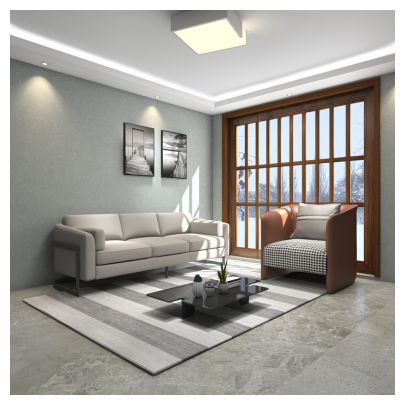

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
import copy
import time
import tqdm
import json
import shutil
import random
import os.path as osp
from PIL import Image
import matplotlib.pyplot as plt
from utils.util import *
from utils.show_point import show_point
from utils.show_relations import show_relations, parse_json_nodes

image_paths = get_file_list(config.input_image)
test_image = image_paths[0]
print(f"Processing image: {test_image}")
plt.figure(figsize=(5, 5))
img = Image.open(test_image)
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
from foundation.detector import BoxDetector
from foundation.indoor_object import IndoorObjectDetector
from foundation.indoor_depth import IndoorDepthEstimator
from foundation.indoor_sam import IndoorSAMEstimator
from foundation.indoor_distance import IndoorDistanceEstimator

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Iterative Object Perception

This cell implements a iterative object detection approach that first detects main objects and then identifies sub-objects within containers. Here's the detailed workflow:

### Stage 1: Initial Object Detection
1. **Container Analysis**
   - Loads container captions and attributes
   - Extracts text descriptions for detection
2. **First Round Detection**
   - Performs initial object detection using the generated tags
   - Visualizes detected objects with bounding boxes
   - Prints detection results including scores and box coordinates

### Stage 2: Sub-object Detection

This stage implements an iterative detection process for objects within containers:
1. **Pre-processing**
   - Crops and expands container regions
   - Prepares individual container images
2. **Hierarchical Detection**
   - Analyzes container contents
   - Performs targeted detection within containers

This iterative approach enables detailed detection of nested objects, improving scene understanding for complex indoor environments.

In [5]:
object_detector = IndoorObjectDetector(config)
output_dir = object_detector._prepare_output_dir(test_image)
container_caption = object_detector._get_container_caption(test_image, output_dir)
print("Indoor objects and container：")
print(json.dumps(container_caption, indent=4, ensure_ascii=False))

Loading VLM model: gpt-4v
Loading model from ckpts/grounding-dino-base


/opt/conda/envs/qwen2vl/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Indoor objects and container：
{
    "object1": {
        "description": "beige three-seater sofa",
        "container": "False"
    },
    "object2": {
        "description": "brown armchair with patterned cushion",
        "container": "False"
    },
    "object3": {
        "description": "gray and white area rug",
        "container": "False"
    },
    "object4": {
        "description": "black low-rise coffee table",
        "container": "True"
    },
    "object5": {
        "description": "left wall-mounted picture frame",
        "container": "False"
    },
    "object6": {
        "description": "right wall-mounted picture frame",
        "container": "False"
    },
    "object7": {
        "description": "large wooden framed window",
        "container": "False"
    },
    "object8": {
        "description": "white ceiling light fixture",
        "container": "False"
    }
}


- Detected box for 'beige three-seater sofa': [0.341, 0.631, 0.465, 0.22], score: 0.894
- Detected box for 'brown armchair with patterned cushion': [0.776, 0.618, 0.26, 0.242], score: 0.923
- Detected box for 'gray and white area rug': [0.428, 0.793, 0.794, 0.316], score: 0.718
- Detected box for 'black low-rise coffee table': [0.513, 0.742, 0.32, 0.126], score: 0.948
- Detected box for 'left wall-mounted picture frame': [0.334, 0.361, 0.088, 0.147], score: 0.645
- Detected box for 'right wall-mounted picture frame': [0.426, 0.374, 0.074, 0.133], score: 0.708
- Detected box for 'large wooden framed window': [0.756, 0.434, 0.414, 0.52], score: 0.675
- Detected box for 'white ceiling light fixture': [0.515, 0.061, 0.205, 0.119], score: 0.743
{
    "boxes": [
        [
            129.56826782226562,
            624.6488037109375,
            688.067626953125,
            888.6680908203125
        ],
        [
            775.5125732421875,
            596.2779541015625,
            1087.

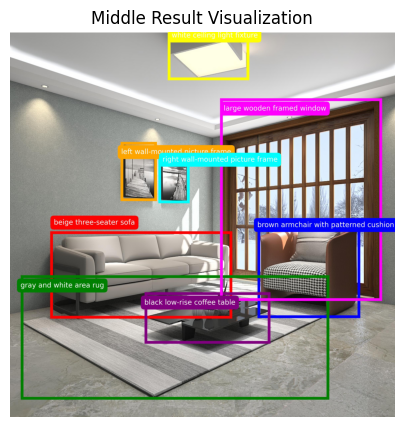

In [6]:
initial_detection = object_detector._perform_initial_detection(container_caption, test_image, output_dir)
formatted_detection = {
    k: [v.tolist() if isinstance(v, torch.Tensor) else v for v in values]
    if isinstance(values, list) else values
    for k, values in initial_detection.items()
}
print(json.dumps(formatted_detection, indent=4))
middle_result_path = initial_detection.get('middle_result_path')
img = Image.open(middle_result_path)  # 使用 PIL 打开图片
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')  # 隐藏坐标轴
plt.title("Middle Result Visualization")
plt.show()

Processing container: black low-rise coffee table
- Detected box for 'white vase with grooved design': [0.447, 0.368, 0.063, 0.327], score: 0.603
- Detected box for 'blue and white patterned vase': [0.511, 0.419, 0.058, 0.187], score: 0.412
- Detected box for 'green plant in white pot': [0.585, 0.243, 0.072, 0.474], score: 0.414
- Detected box for 'stack of white books': [0.585, 0.313, 0.199, 0.207], score: 0.460
- Failed to select valid box for: 'black rectangular object on books'
Added 4 sub-objects

                                  Middle Detection Results Summary                                  
No.      Object                                  Confidence    Position [x1, y1, x2, y2]          
----------------------------------------------------------------------------------------------------
1       black low-rise coffee table             0.948        [423.2, 814.8, 807.2, 966.4]       
2       brown armchair with patterned cushion   0.923        [775.5, 596.3, 1087.9, 886.6]    

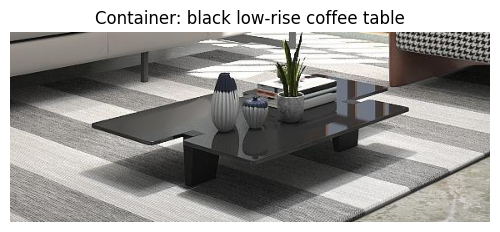

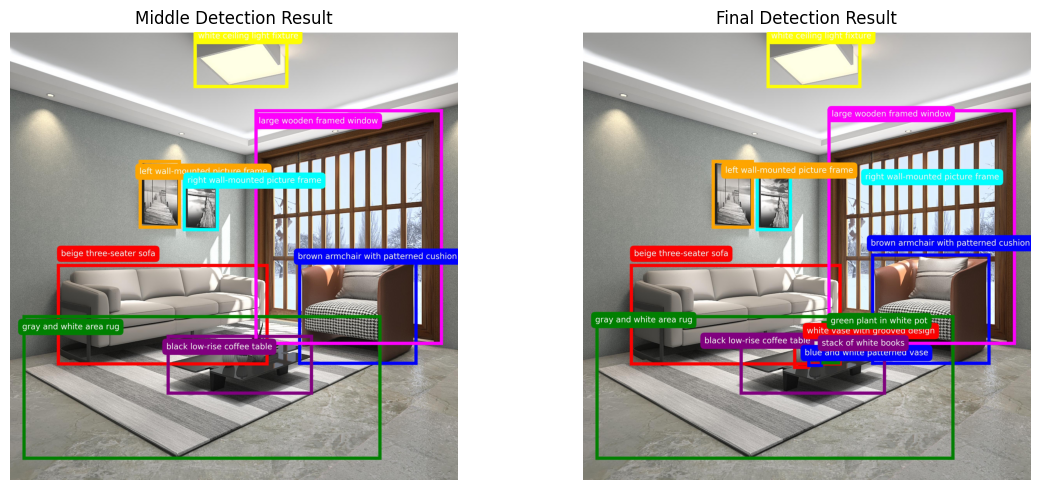

In [7]:
container_results = object_detector._process_containers(initial_detection, test_image, output_dir)
all_results = object_detector._save_final_results(container_results, test_image, output_dir)

# Get middle detection results
print("\n" + "="*100)
print("Middle Detection Results Summary".center(100))
print("="*100)

# Sort middle detections by confidence score
middle_results = sorted(zip(all_results['pred_middle'], 
                          all_results['score_middle'], 
                          all_results['box_middle']), 
                      key=lambda x: x[1], reverse=True)

# Print header
print("No.      Object                                  Confidence    Position [x1, y1, x2, y2]          ")
print("-"*100)

# Print each middle detection result
for idx, (phrase, score, box) in enumerate(middle_results, 1):
    box_str = f"[{box[0]:.1f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}]"
    print(f"{idx:<8}{phrase:<40}{score:.3f}{' '*8}{box_str:<35}")

print("-"*100)
print(f"Total middle objects detected: {len(middle_results)}\n")

# Print container detection results if any
if all_results['container_meta']:
    for container_name, container_info in all_results['container_meta'].items():
        print("\n" + "="*100)
        print(f"Container Detection Results for: {container_name}".center(100))
        print("="*100)
        
        # Sort container detections by confidence score
        container_results = sorted(zip(container_info['predictions'], 
                                    container_info['scores'], 
                                    container_info['boxes']), 
                                key=lambda x: x[1], reverse=True)
        
        # Print header
        print("No.      Object                                  Confidence    Position [x1, y1, x2, y2]          ")
        print("-"*100)
        
        # Print each container detection result
        for idx, (phrase, score, box) in enumerate(container_results, 1):
            box_str = f"[{box[0]:.1f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}]"
            print(f"{idx:<8}{phrase:<40}{score:.3f}{' '*8}{box_str:<35}")
        
        print("-"*100)
        print(f"Total objects detected in container: {len(container_results)}\n")

# First, handle container results
num_containers = len(all_results['container_meta'])
if num_containers > 0:
    # Calculate rows needed for containers (assuming max 3 per row)
    container_rows = (num_containers + 2) // 3
    plt.figure(figsize=(15, 5 * container_rows))
    
    for idx, (container_name, container_info) in enumerate(all_results['container_meta'].items()):
        plt.subplot(container_rows, 3, idx + 1)
        img_container = Image.open(container_info['container_path'])
        plt.imshow(img_container)
        plt.title(f'Container: {container_name}')
        plt.axis('off')
        img_container.close()
    
    plt.tight_layout()
    plt.show()

# Then display middle and final results
plt.figure(figsize=(12, 5))

# Middle detection result
plt.subplot(1, 2, 1)
img_middle = Image.open(all_results['middle_result_path'])
plt.imshow(img_middle)
plt.title('Middle Detection Result')
plt.axis('off')
img_middle.close()

# Final detection result
plt.subplot(1, 2, 2)
img_final = Image.open(all_results['final_result_path'])
plt.imshow(img_final)
plt.title('Final Detection Result')
plt.axis('off')
img_final.close()

plt.tight_layout()
plt.show()

# Depth Estimation Visualization

This cell demonstrates the depth estimation process using the DepthAnything model, which provides both normalized and metric depth maps for the input image.

### Process Overview
1. **Depth Estimation**
   - Uses DepthAnything model to generate depth maps
   - Produces both normalized and metric depth values
   - `depth_map_norm`: Normalized depth map (0-255 range)
   - `metric_depth`: Actual depth values in meters

2. **Display Components**
   - **Left subplot**: Original input image
   - **Right subplot**: Depth map visualization

In [8]:
# Initialize depth estimator
depth_estimator = IndoorDepthEstimator(config)

Loading depth estimation model...
Using pretrained resource local::/llm-cfs-nj/person/harryyhwang/ft_local/ft_local/ROOT/foundation/Depth_Anything/depth_anything_metric_depth_indoor.pt
Loaded successfully


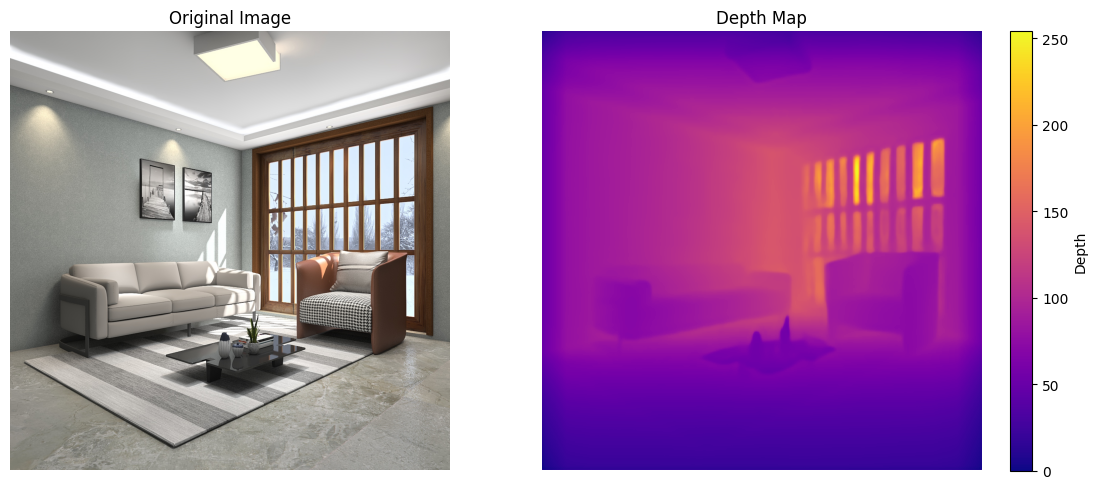

In [9]:
# Get depth map
depth_map_norm, metric_depth = depth_estimator.process_image(test_image)

# Visualize depth map
plt.figure(figsize=(12, 5))

# Original image
plt.subplot(121)
img = Image.open(test_image)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# Depth map
plt.subplot(122)
plt.imshow(depth_map_norm, cmap='plasma')  # plasma colormap works well for depth visualization
plt.colorbar(label='Depth')
plt.title("Depth Map")
plt.axis('off')

plt.tight_layout()
plt.show()

# Segment Anything Model Processing

### Processing Steps
1. **Mask Generation**
   - Takes detected bounding boxes as prompts
   - Generates precise segmentation masks for each object
   - Filters and selects valid masks
   - 
2. **Visualization**
   - **Left panel**: Original input image
   - **Right panel**: Segmentation visualizationce

In [10]:
# Initialize SAM estimator
sam_estimator = IndoorSAMEstimator(config)

Loading SAM model...


Processing SAM segmentation...


Processing masks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.97it/s]


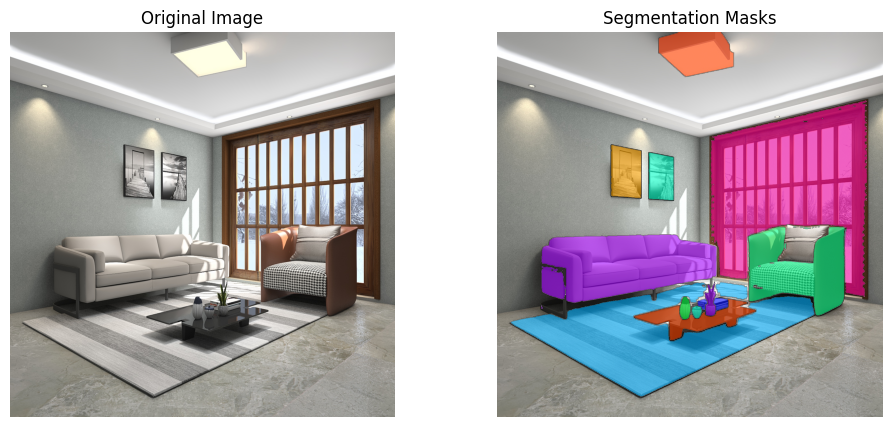


Successfully segmented 12 objects


In [11]:
# Segment detected objects
print("Processing SAM segmentation...")
boxes, scores, pred_phrases = all_results["boxes"], all_results["scores"], all_results["pred_phrases"]
all_masks, selected_idx = sam_estimator.process_image(test_image, boxes)

# Update boxes and pred_phrases to match selected masks
boxes = [boxes[i] for i in selected_idx]
pred_phrases = [pred_phrases[i] for i in selected_idx]
masks = [all_masks[i] for i in selected_idx]

# Visualize segmentation results
plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace=0.1)

# Left plot: Original image
plt.subplot(121)
img = Image.open(test_image).convert("RGB")
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# Right plot: Segmentation results
plt.subplot(122)
plt.imshow(img)  # Show original image as background
# Overlay all masks
for mask in masks:
    sam_estimator._show_mask(mask, plt.gca(), random_color=True)
plt.title("Segmentation Masks")
plt.axis('off')

plt.show()

print(f"\nSuccessfully segmented {len(masks)} objects")

# Distance and Size Estimation

### Processing Components
1. **Distance Estimation**
   - Combines segmentation masks with metric depth map
   - Calculates 3D positions and dimensions for each object
   - Generates point cloud representations

2. **Object Properties Extraction**
   - `relative_positions`: 3D coordinates relative to camera
   - `point_clouds`: 3D point cloud for each object
   - `colors`: RGB color information
   - `sizes`: Physical dimensions (width × height × depth) in meters

3. **Visualization**
   - Shows up to 5 objects in a grid layout
   - For each object displays:
     - Segmented object image (masked from original)
     - Object label
     - Physical dimensions in meters
   - Grid automatically adjusts based on number of objects

In [12]:
# Initialize distance estimator
distance_estimator = IndoorDistanceEstimator(config)

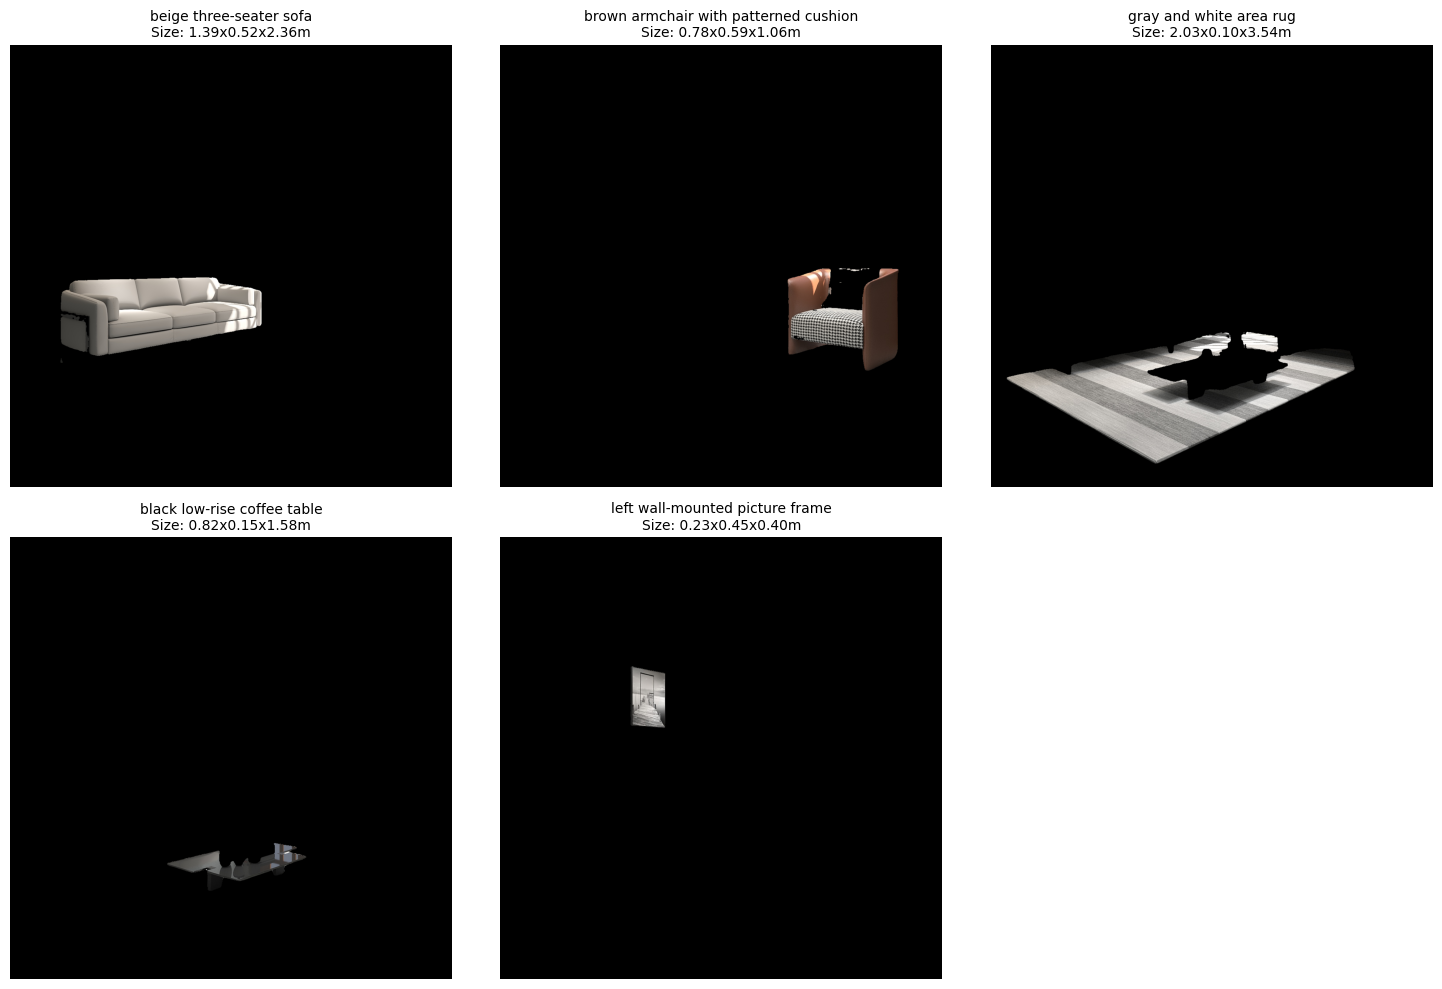


Displayed 5 segmented objects

                                Sample of Object Distances                                

Sample of relative distances (5 random pairs):
------------------------------------------------------------------------------------------
Distance between beige three-seater sofa        and stack of white books          : 0.98 meters
Distance between right wall-mounted picture frame and blue and white patterned vase : 2.47 meters
Distance between gray and white area rug        and white vase with grooved design: 0.22 meters
Distance between brown armchair with patterned cushion and black low-rise coffee table   : 1.14 meters
Distance between black low-rise coffee table    and blue and white patterned vase : 0.04 meters

                                  Sample of Object Sizes                                  
Object Dimensions (Length x Width x Height):
------------------------------------------------------------------------------------------
black low-rise coffee

In [13]:
relative_positions, point_clouds, colors, sizes = distance_estimator.process_image(
    test_image, masks, pred_phrases, metric_depth
)

# Show segmentation images for the first 5 objects
num_objects = min(5, len(masks))
fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.1)

# Calculate number of rows and columns
n_cols = 3
n_rows = (num_objects + n_cols - 1) // n_cols

for i in range(num_objects):
    plt.subplot(n_rows, n_cols, i+1)
    img = cv2.cvtColor(cv2.imread(test_image), cv2.COLOR_BGR2RGB)
    masked_img = distance_estimator._apply_mask_to_image(img, masks[i])
    plt.imshow(masked_img)
    plt.title(f"{pred_phrases[i]}\nSize: {sizes[i][0]:.2f}x{sizes[i][1]:.2f}x{sizes[i][2]:.2f}m", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\nDisplayed {num_objects} segmented objects")

# Sample and print 5 random distances
print("\n" + "="*90)
print("Sample of Object Distances".center(90))
print("="*90)

sample_size = min(5, len(relative_positions))
if sample_size > 0:
    print("\nSample of relative distances (5 random pairs):")
    print("-"*90)
    for pos in random.sample(relative_positions, sample_size):
        obj1, obj2 = pos['object_pair']
        print(f"Distance between {obj1:<30} and {obj2:<30}: {pos['distance']:.2f} meters")

# Sample and print 5 random sizes
print("\n" + "="*90)
print("Sample of Object Sizes".center(90))
print("="*90)
print("Object Dimensions (Length x Width x Height):")
print("-"*90)

sample_size = min(5, len(pred_phrases))
if sample_size > 0:
    for phrase, size in random.sample(list(zip(pred_phrases, sizes)), sample_size):
        print(f"{phrase:<40}: {size[0]:.2f}m x {size[1]:.2f}m x {size[2]:.2f}m")

# Phrase Simplification and Final Scene Graph Generation

### 1. Phrase Simplification
- **Model Setup**
  - Uses Qwen2.5 model for phrase simplification

- **Simplification Process**
  - Processes each detected object phrase
  - Handles duplicate phrases with numerical suffixes
  - Maintains unique identifiers for identical objects

### 2. Scene Visualization and Graph Generation
- **Point Cloud Visualization**
  - Creates point data representation of the scene
  - 
- **Scene Graph Generation**
  - Uses Qwen2-VL model for relationship analysis
  - Incorporates structural elements (wall, ceiling, floor)
  - Generates comprehensive scene description including:
    - Object relationships

In [14]:
from api.qwen25_sft import Qwen25Handler

# Initialize the phrase simplification model
phrase_simplify = Qwen25Handler()
phrase_simplify.initialize_llm(checkpoint=config.phrase_simplify_checkpoint)

# Load prompt template
with open("prompt/phrase_simplify.txt", "r", encoding="utf-8") as f:
    phrase_simplify_prompt = f.read()

# Define simplification function
def simplify_single_phrase(phrase):
    query = phrase_simplify_prompt.replace("[Insert the phrase here]", phrase)
    simplified_phrase = phrase_simplify.run_llm(query)
    return json.loads(simplified_phrase)["simplified_phrase"]

# Process all phrases
simplified_results = [simplify_single_phrase(phrase) for phrase in pred_phrases]

# Handle duplicates with numbering
phrase_count = {}
new_pred_phrases = []
for phrase in simplified_results:
    phrase_count[phrase] = phrase_count.get(phrase, 0) + 1
    new_phrase = f"{phrase}_{phrase_count[phrase]}" if phrase_count[phrase] > 1 else phrase
    new_pred_phrases.append(new_phrase)

print(f"Simplified {len(new_pred_phrases)} phrases\n")
print("Phrase Simplification Results:")
for orig, simp in zip(pred_phrases, new_pred_phrases):
    print(f"Original: {orig} -> Simplified: {simp}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Simplified 12 phrases

Phrase Simplification Results:
Original: beige three-seater sofa -> Simplified: beige sofa
Original: brown armchair with patterned cushion -> Simplified: brown patterned armchair
Original: gray and white area rug -> Simplified: gray white area rug
Original: black low-rise coffee table -> Simplified: black coffee table
Original: left wall-mounted picture frame -> Simplified: wall-mounted picture frame
Original: right wall-mounted picture frame -> Simplified: wall-mounted frame
Original: large wooden framed window -> Simplified: wooden framed window
Original: white ceiling light fixture -> Simplified: white ceiling light
Original: white vase with grooved design -> Simplified: white grooved vase
Original: blue and white patterned vase -> Simplified: blue and white vase
Original: green plant in white pot -> Simplified: green plant in pot
Original: stack of white books -> Simplified: stack of books


Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

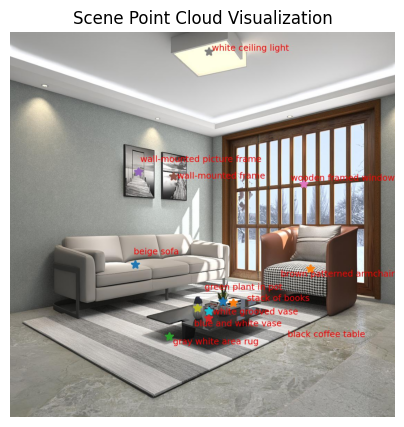

The white ceiling light is attached to the ceiling. The wooden framed window, wall-mounted picture frame, and wall-mounted frame are hanging on the wall. The gray white area rug is supported by the floor, and on top of the gray white area rug, there is a black coffee table which supports a stack of books, a white grooved vase, and a blue and white vase. The beige sofa and brown patterned armchair are also supported by the floor.
```json
{
    "ceiling": {
        "attach": [
            {
                "white ceiling light": {}
            }
        ]
    },
    "wall": {
        "hang": [
            {
                "wooden framed window": {}
            },
            {
                "wall-mounted picture frame": {}
            },
            {
                "wall-mounted frame": {}
            }
        ]
    },
    "floor": {
        "support": [
            {
                "gray white area rug": {
                    "support": [
                        {
               

In [15]:
from prompt.ssg_prompt import str1, str2
from api.qwen2vl_sft import Qwen2VLHandler
my_vlm = Qwen2VLHandler()
my_vlm.initialize_llm(checkpoint=config.qwen_checkpoint)

visualization_path = show_point(test_image, masks, new_pred_phrases, output_dir=output_dir)

# 显示可视化结果
plt.figure(figsize=(5, 5))
img = Image.open(visualization_path)
plt.imshow(img)
plt.axis('off')
plt.title('Scene Point Cloud Visualization')
plt.show()

# 继续处理场景图生成
object_list = new_pred_phrases + ['wall', 'ceiling', 'floor']
query = str1 + ", ".join(object_list) + str2
answer = my_vlm.run_llm(query, visualization_path)
with open(osp.join(output_dir, "answer.json"), "w") as f:
    json.dump(extract_json_from_string(answer), f, indent=4)
print(answer)

# Scene Relationship Visualization

- Creates a hierarchical visualization showing:
 - Object relationships
 - Parent-child relationships


3_relations.jpg


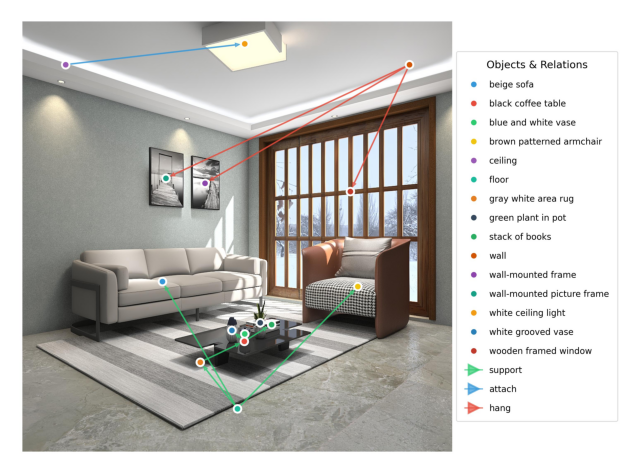

In [16]:
relations = extract_json_from_string(answer)
relations = parse_json_nodes(relations)
output_path = show_relations(test_image, masks, new_pred_phrases, relations, output_dir=output_dir)
plt.figure(figsize=(8, 8))
plt.imshow(plt.imread(output_path))
plt.axis('off')
plt.show()